# Predicting Business Popularity
##### Pytorch Geometric implementation with NetworkX graph

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 2.6MB 318kB/s 
     |████████████████████████████████| 1.5MB 262kB/s 
     |████████████████████████████████| 1.0MB 315kB/s 
     |████████████████████████████████| 215kB 7.7MB/s 
     |████████████████████████████████| 235kB 13.6MB/s 
     |████████████████████████████████| 2.2MB 18.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as pyg_nn
import torch_geometric.transforms as pyg_transforms
import torch_cluster

import networkx as nx
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating the network graph datasets

We use NetworkX to read and parse the graph into train/validate/test sets. We load these into DataLoader to use mini-batching.

In [4]:
G = nx.read_gpickle("./drive/MyDrive/Colab Notebooks/restaurant_graph/best/classification/weighted_visit_count_full.gpickle")

In [5]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 29963
Number of edges: 491371


In [6]:
H = Graph(G)
dataset = GraphDataset(graphs=[H], task='node')

In [7]:
print(dataset.graphs[0])

Graph(G=[], edge_index=[2, 982742], edge_label_index=[2, 982742], node_feature=[29963, 439], node_label=[29963], node_label_index=[29963], node_type=[29963], task=[])


In [8]:
dataset.graphs[0].node_label = torch.LongTensor(dataset.graphs[0].node_label)
print(dataset.graphs[0].node_label)
print(dataset.graphs[0].node_label_index)

tensor([2, 2, 1,  ..., 2, 2, 1])
tensor([    0,     1,     2,  ..., 29960, 29961, 29962])


In [9]:
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1], shuffle=True)

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=16)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=16)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=16)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels
print(f"There are {num_node_features} features and {num_classes} labels.")

There are 439 features and 3 labels.


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the popularity category, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_node_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=539, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
x = dataset.graphs[0].node_feature
y = dataset.graphs[0].node_label

print(x.size())
print(y.size())

torch.Size([29963, 539])
torch.Size([29963])


In [ ]:
import numpy as np

mask = np.random.rand(1, y.size()[0])

train_mask = (mask < 0.9)[0]
test_mask = (mask >= 0.9)[0]

print(train_mask)
print(test_mask)

[ True  True False ... False  True  True]
[False False  True ...  True False False]


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(x)  # Perform a single forward pass.
      loss = criterion(out[train_mask], y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 500):
    loss = train()
    if epoch % 5 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 005, Loss: 0.9930
Epoch: 010, Loss: 0.9109
Epoch: 015, Loss: 0.8533
Epoch: 020, Loss: 0.8120
Epoch: 025, Loss: 0.7920
Epoch: 030, Loss: 0.7753
Epoch: 035, Loss: 0.7680
Epoch: 040, Loss: 0.7613
Epoch: 045, Loss: 0.7510
Epoch: 050, Loss: 0.7460
Epoch: 055, Loss: 0.7408
Epoch: 060, Loss: 0.7362
Epoch: 065, Loss: 0.7350
Epoch: 070, Loss: 0.7320
Epoch: 075, Loss: 0.7281
Epoch: 080, Loss: 0.7278
Epoch: 085, Loss: 0.7237
Epoch: 090, Loss: 0.7243
Epoch: 095, Loss: 0.7232
Epoch: 100, Loss: 0.7197
Epoch: 105, Loss: 0.7164
Epoch: 110, Loss: 0.7155
Epoch: 115, Loss: 0.7148
Epoch: 120, Loss: 0.7121
Epoch: 125, Loss: 0.7141
Epoch: 130, Loss: 0.7110
Epoch: 135, Loss: 0.7113
Epoch: 140, Loss: 0.7088
Epoch: 145, Loss: 0.7072
Epoch: 150, Loss: 0.7097
Epoch: 155, Loss: 0.7088
Epoch: 160, Loss: 0.7080
Epoch: 165, Loss: 0.7090
Epoch: 170, Loss: 0.7047
Epoch: 175, Loss: 0.7077
Epoch: 180, Loss: 0.7040
Epoch: 185, Loss: 0.7049
Epoch: 190, Loss: 0.7036
Epoch: 195, Loss: 0.7022
Epoch: 200, Loss: 0.7023


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7032


## Logistic Regression

In [ ]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.2, random_state = 1)

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lm.score(X_test, y_test)

0.6686133822793259

## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.


In [29]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        conv_model = self.build_conv_model(args["model"])
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_size, hidden_size))

        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_size, hidden_size))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index):
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GAT':
            return pyg_nn.GATConv
        elif model_type == "GraphSage":
            return pyg_nn.SAGEConv
        elif model_type == "TransformerConv":
            return pyg_nn.TransformerConv
        else:
            raise ValueError(
                "Model {} unavailable, please add it to GNN.build_conv_model.".format(model_type))
            

In [31]:
def train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    losses = []
    accuracies = [[], [], []] # train / validate / test

    for epoch in range(1, args['epochs']+1):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch.node_feature, batch.edge_index)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = test_gnn(train_loader, model, device)
        val_acc = test_gnn(val_loader, model, device)
        test_acc = test_gnn(test_loader, model, device)

        if epoch % 5 == 0:
          print(f"Epoch {epoch}: Train: {train_acc:.4f}, Validation: {val_acc:.4f}. Test: {test_acc:.4f}, Loss: {total_loss:.4f}")

        losses.append(round(total_loss, 4))
        accuracies[0].append(train_acc)
        accuracies[1].append(val_acc)
        accuracies[2].append(test_acc)

    return (model, losses, accuracies)

def test_gnn(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch.node_feature, batch.edge_index)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

In [32]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 250})'''))

args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 64,
    "epochs" : 300,
    "lr" : 0.01,
    "num_layers": 2,
    "model": "GraphSage" # [GraphSage, GAT, GCN, TransformerConv]
}

gnn_model, losses, accuracies = train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])

<IPython.core.display.Javascript object>

GNN(
  (convs): ModuleList(
    (0): SAGEConv(439, 64)
    (1): SAGEConv(64, 64)
  )
  (post_mp): Linear(in_features=64, out_features=3, bias=True)
)
Epoch 5: Train: 0.5347, Validation: 0.5234. Test: 0.5315, Loss: 1.0798
Epoch 10: Train: 0.5807, Validation: 0.5838. Test: 0.5963, Loss: 1.0037
Epoch 15: Train: 0.6296, Validation: 0.6285. Test: 0.6263, Loss: 0.8875
Epoch 20: Train: 0.6270, Validation: 0.6272. Test: 0.6216, Loss: 0.8288
Epoch 25: Train: 0.6469, Validation: 0.6529. Test: 0.6353, Loss: 0.8021
Epoch 30: Train: 0.6595, Validation: 0.6646. Test: 0.6486, Loss: 0.7764
Epoch 35: Train: 0.6637, Validation: 0.6742. Test: 0.6473, Loss: 0.7618
Epoch 40: Train: 0.6713, Validation: 0.6742. Test: 0.6577, Loss: 0.7478
Epoch 45: Train: 0.6750, Validation: 0.6809. Test: 0.6573, Loss: 0.7369
Epoch 50: Train: 0.6770, Validation: 0.6799. Test: 0.6623, Loss: 0.7286
Epoch 55: Train: 0.6809, Validation: 0.6846. Test: 0.6680, Loss: 0.7198
Epoch 60: Train: 0.6823, Validation: 0.6842. Test: 0.6640, 

In [45]:
for name, param in gnn_model.named_parameters():
    print("------------- ", name, " -------------")
    param_list = list(param)
    size = list(param_list[0].size())
    if len(size) == 0:
      print("Size: ", 1, " x ", len(param_list))
    else:
      print("Size: ", size[0], " x ", len(param_list))
    print(param)

-------------  convs.0.lin_l.weight  -------------
Size:  439  x  64
Parameter containing:
tensor([[-3.6532e-03, -3.6113e-02,  2.2147e-02,  ...,  3.2954e-02,
          3.0114e-03, -1.2737e-02],
        [-4.0144e-04, -9.3472e-05, -1.2300e-03,  ..., -8.0257e-03,
         -1.0912e-02,  1.0064e-05],
        [-4.4944e-03, -2.3377e-02, -2.6103e-02,  ..., -6.2040e-02,
         -5.5026e-02, -3.1109e-04],
        ...,
        [-9.7462e-03,  1.6269e-02, -1.6011e-02,  ...,  1.8705e-02,
         -5.5136e-04, -4.0489e-02],
        [ 3.3739e-02,  6.3997e-02,  8.8781e-02,  ...,  6.8678e-02,
          8.6990e-02, -9.7541e-04],
        [-6.3522e-02, -3.3316e-02, -6.1638e-03,  ..., -5.3093e-02,
         -2.3975e-02, -7.5216e-03]], device='cuda:0', requires_grad=True)
-------------  convs.0.lin_l.bias  -------------
Size:  1  x  64
Parameter containing:
tensor([ 0.1020,  0.0021, -0.0301, -0.2460,  0.1665, -0.0169, -0.0669, -0.0277,
         0.2861,  0.3095,  0.0971,  0.1417, -0.0731, -0.0161, -0.0188,  0

### Plotting training data 

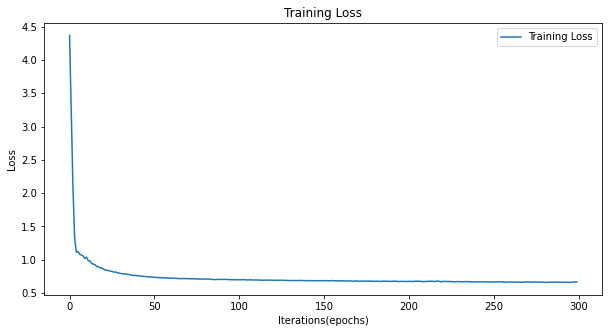

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses, label="Training Loss")
plt.xlabel("Iterations(epochs)")
plt.ylabel("Loss")
plt.legend()
plt.show()

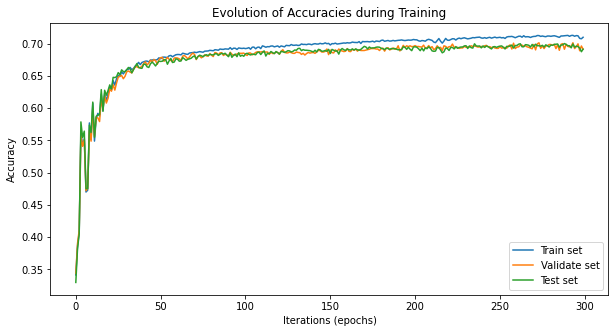

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Evolution of Accuracies during Training")
plt.plot(accuracies[0],label="Train set")
plt.plot(accuracies[1],label="Validate set")
plt.plot(accuracies[2],label="Test set")
plt.xlabel("Iterations (epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Report

In [27]:
final_test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=len(dataset_test))

y_pred = None
y_true = None

gnn_model.eval()
for batch in final_test_loader:
    batch.to("cuda")
    logits = gnn_model(batch.node_feature, batch.edge_index)
    y_pred = logits[batch.node_label_index].max(1)[1]
    y_true = batch.node_label

In [28]:
from sklearn.metrics import classification_report

target_names = ['Low', 'Middle', 'High']
print(classification_report(y_true.cpu(), y_pred.cpu(), target_names=target_names))

              precision    recall  f1-score   support

         Low       0.63      0.83      0.72       985
      Middle       0.54      0.40      0.46      1012
        High       0.80      0.77      0.78      1000

    accuracy                           0.66      2997
   macro avg       0.66      0.66      0.65      2997
weighted avg       0.66      0.66      0.65      2997



## GNN Explain

In [ ]:
data = dataset[0]
data.to(args["device"])
x, edge_index = data.node_feature, data.edge_index

In [ ]:
explainer = pyg_nn.GNNExplainer(gnn_model, epochs=200, return_type='log_prob')

In [ ]:
import random
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 150})'''))

final_feature_mask = [0] * num_node_features
count = 2000

for i in range(0, count):
  node_idx = random.randint(0, G.number_of_nodes()-1)
  node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
  node_feat_mask_list = node_feat_mask.tolist()
  final_feature_mask = [sum(x) for x in zip(final_feature_mask, node_feat_mask_list)]


final_feature_mask = [round(value / count, 3) for value in final_feature_mask]

<IPython.core.display.Javascript object>

Explain node 19327: 100%|██████████| 200/200 [00:00<00:00, 253.73it/s]


In [ ]:
print(final_feature_mask)
print(len(final_feature_mask))

[0.56, 0.514, 0.47, 0.431, 0.578, 0.569, 0.564, 0.552, 0.307, 0.456, 0.418, 0.276, 0.237, 0.306, 0.261, 0.312, 0.267, 0.234, 0.236, 0.271, 0.285, 0.19, 0.182, 0.235, 0.172, 0.188, 0.196, 0.2, 0.282, 0.171, 0.195, 0.189, 0.2, 0.208, 0.208, 0.171, 0.199, 0.204, 0.187, 0.163, 0.181, 0.183, 0.226, 0.175, 0.181, 0.169, 0.179, 0.158, 0.168, 0.151, 0.189, 0.157, 0.182, 0.153, 0.156, 0.163, 0.18, 0.204, 0.17, 0.173, 0.158, 0.142, 0.145, 0.193, 0.162, 0.169, 0.142, 0.163, 0.147, 0.179, 0.144, 0.142, 0.143, 0.146, 0.143, 0.174, 0.142, 0.151, 0.144, 0.143, 0.164, 0.144, 0.142, 0.142, 0.143, 0.143, 0.144, 0.143, 0.142, 0.144, 0.142, 0.142, 0.143, 0.142, 0.145, 0.144, 0.143, 0.143, 0.142, 0.147, 0.145, 0.143, 0.142, 0.143, 0.142, 0.145, 0.142, 0.142, 0.142, 0.143, 0.143, 0.143, 0.142, 0.145, 0.143, 0.144, 0.143, 0.143, 0.146, 0.142, 0.143, 0.143, 0.142, 0.143, 0.142, 0.143, 0.145, 0.142, 0.142, 0.143, 0.143, 0.143, 0.143, 0.142, 0.142, 0.143, 0.143, 0.142, 0.143, 0.143, 0.142, 0.147, 0.143, 0.143, 

In [ ]:
feature_mask_tuples = []
for index, value in enumerate(final_feature_mask):
  feature_mask_tuples.append((value, index))

In [ ]:
feature_mask_tuples[:10]

[(0.56, 0),
 (0.514, 1),
 (0.47, 2),
 (0.431, 3),
 (0.578, 4),
 (0.569, 5),
 (0.564, 6),
 (0.552, 7),
 (0.307, 8),
 (0.456, 9)]

In [ ]:
feature_mask_tuples.sort(reverse=True)
feature_mask_tuples[:15]

[(0.578, 4),
 (0.577, 436),
 (0.569, 5),
 (0.564, 6),
 (0.56, 0),
 (0.552, 7),
 (0.514, 437),
 (0.514, 1),
 (0.47, 2),
 (0.456, 9),
 (0.431, 3),
 (0.418, 10),
 (0.312, 15),
 (0.307, 8),
 (0.306, 13)]

1: RestaurantsGoodForGroups

4: RestaurantsPriceRange2

436: Temporal Popularity Skew

7: Caters

6: RestaurantsDelivery

5: GoodForKids

0: OutdoorSeating

437: User influence

9: RestaurantsTakeOut

62: